In [6]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np



In [7]:
def read_file(filename):
    with open(filename, "r") as fp:
        lines = fp.readlines()
    data = {}
    batch_sums = []
    for line in lines:
        if "branches_num" in line:
            branch_num = int(line.split(":")[1].strip())
        if "batch_sum" in line:
            batch_sum = int(line.split(":")[1].strip())
            batch_sums.append(batch_sum)
        if "Time" in line:
            if "(s)" in line:
                jct = float(line.split(":")[1].split("(s)")[0].strip())
            else:
                jct = float(line.split(":")[1].strip())
            data[branch_num] = {"batch_sum": batch_sums, "jct": jct}
            batch_sums = []
    return data

In [8]:
parrot = read_file('parrot_main.log')
parrot_wo_share = read_file('parrot_without_share.log')
vllm_lat = read_file('fschat_vllm_lat.log')
vllm_thr = read_file('fschat_vllm_thr.log')

In [9]:
print('parrot', parrot)
# print('vllm', vllm)

parrot {4: {'batch_sum': [4456, 17339, 21096, 24388, 21096, 24388, 21096, 24388, 21096, 24388], 'jct': 187.470137846}, 8: {'batch_sum': [8912, 33654, 42237, 47938, 42237, 47938, 42237, 47938, 42237, 47938], 'jct': 203.865291168}, 12: {'batch_sum': [13368, 50993, 63333, 72326, 63333, 72326, 63333, 72326, 63333, 72326], 'jct': 236.072279322}, 16: {'batch_sum': [17824, 67308, 84474, 95876, 84474, 95876, 84474, 95876, 84474, 95876], 'jct': 252.11149429300002}}


In [10]:

# client_nums = [10, 15, 20, 25]
branch_nums = [4,8,12,16]
systems = ['parrot', 'parrot w/o share', 'vllm_thr', 'vllm_lat']
hatches = ['', '\\', '/', 'x']
colors = [
"#d73027",
"#fee090",
"#91bfdb",
"#4575b4"]

C:\Users\zhehan\AppData\Local\Temp\ipykernel_10520\1605757125.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


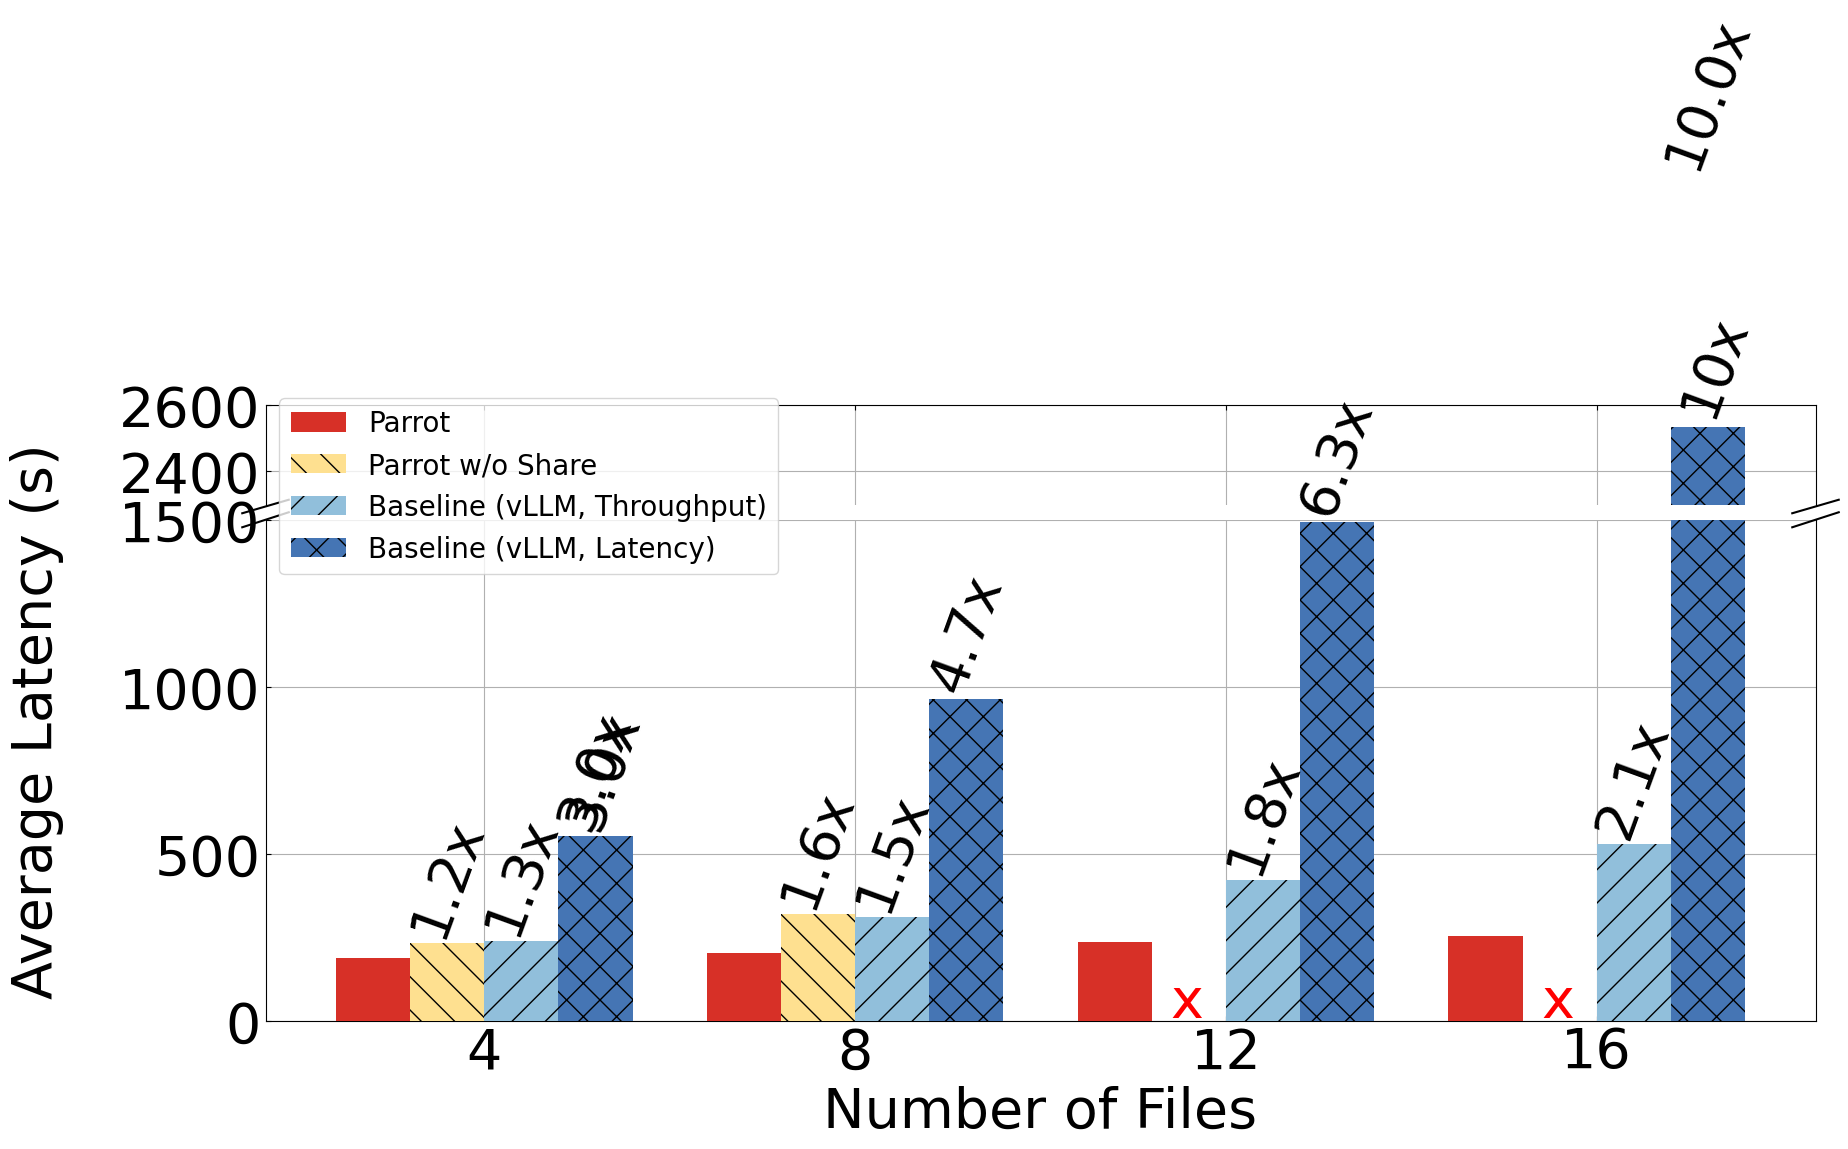

In [12]:
import matplotlib.gridspec as gridspec 
# Organize the data
data = {
    "parrot": parrot,
    "parrot w/o share": parrot_wo_share,
    "vllm_lat": vllm_lat,
    "vllm_thr": vllm_thr
}

names = {
    "parrot": "Parrot",
    "parrot w/o share": "Parrot w/o Share",
    "vllm_lat": "Baseline (vLLM, Latency)",
    "vllm_thr": "Baseline (vLLM, Throughput)",
}

# Generate the chart
x = np.arange(len(branch_nums))
width = 0.2

# # Sample data  
# x = np.linspace(0, 10, 100)  
# y = np.exp(x)  
  
fig = plt.figure(figsize=(20, 8))  
  
# Create a GridSpec with two rows and one column, and set the height ratio  
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5], hspace=0.05)  
  
# Create the two subplots using the gridspec  
ax = fig.add_subplot(gs[0])  
ax2 = fig.add_subplot(gs[1])  

plt.grid(True)
rects = []
for i, system in enumerate(systems):
    for _ in branch_nums:
        if _ not in data[system]:
            data[system][_] = {'jct' : 0}
    avg = [data[system][_]['jct'] for _ in branch_nums]
    rect = ax.bar(x - width*1.5 + i*width, avg, width,  hatch = hatches[i], color = colors[i], label=names[system],zorder=3) # hatches
    rect = ax2.bar(x - width*1.5 + i*width, avg, width,  hatch = hatches[i], color = colors[i], label=names[system],zorder=3) # hatches
    rects.append(rect)

for i, system in enumerate(systems):
    # Add speedup values
    if system != 'parrot': #'vllm_lat':
        speedup_values = [data[system][_]['jct']/data['parrot'][_]['jct'] for _ in branch_nums]
        for rect, speedup in zip(rects[i], speedup_values):
            if speedup < 0.1 :#or speedup > 10 or (speedup >=4.3 and speedup <=5) or (speedup >=2.9 and speedup <=3.1):
                continue
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width() / 2, height,
                    '{:.1f}x'.format(speedup),
                    ha='center', va='bottom', rotation=70,
                    fontsize=40)

ax2.text(1.85, 10, 'x', color='r', fontsize=40)
ax2.text(2.85, 10, 'x', color='r', fontsize=40)
ax.text(3.2, 2580, '10x', fontsize=40, rotation = 70)
ax2.text(0.2, 590, '3.0x', fontsize=40, rotation = 70)

# Zoom in to different parts of the y-axis on each axis  
ax.set_ylim(2300, 2600)  # upper part  
ax2.set_ylim(0, 1500)    # lower part  

ax.grid(True)

# Hide the spines between ax and ax2  
ax.spines['bottom'].set_visible(False)  
ax2.spines['top'].set_visible(False)  
ax.xaxis.tick_top()  
ax.tick_params(labeltop=False)  # Don't put tick labels at the top  
ax2.xaxis.tick_bottom()  
# Add diagonal lines to indicate the break in the axis  
d = .015  # size of the diagonal lines in axes coordinates  
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)  
ax.plot((-d, +d), (-d-0.07, +8*d-0.07), **kwargs)        # top-left diagonal  
ax.plot((1 - d, 1 + d), (-d-0.07, +8*d-0.07), **kwargs)  # top-right diagonal  


kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes  
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal  
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal  

ax.tick_params(axis='y', labelsize=40, direction='in')
ax.tick_params(axis='x', labelsize=40, direction='in')
ax2.tick_params(axis='y', labelsize=40, direction='in')
ax2.tick_params(axis='x', labelsize=40, direction='in')

ax2.set_xlabel('Number of Files', fontsize=40)
ax2.set_ylabel('Average Latency (s)', fontsize=40)
ax.set_xticks([_ for _ in x])
ax2.set_xticks([_ for _ in x])
ax2.set_xticklabels(branch_nums)
ax2.yaxis.set_label_coords(-0.13, 0.6)
plt.legend(loc='upper left', prop = { "size": 20 }, bbox_to_anchor= (0.0, 1.27))

plt.tight_layout()
# plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2) 
plt.savefig('multiagent.pdf',bbox_inches="tight")

In [344]:
# Memory
no_shared = [1525, 2997, 4000, 4000]# 4000, 4000]
shared = [1011, 1306, 1536, 1756]

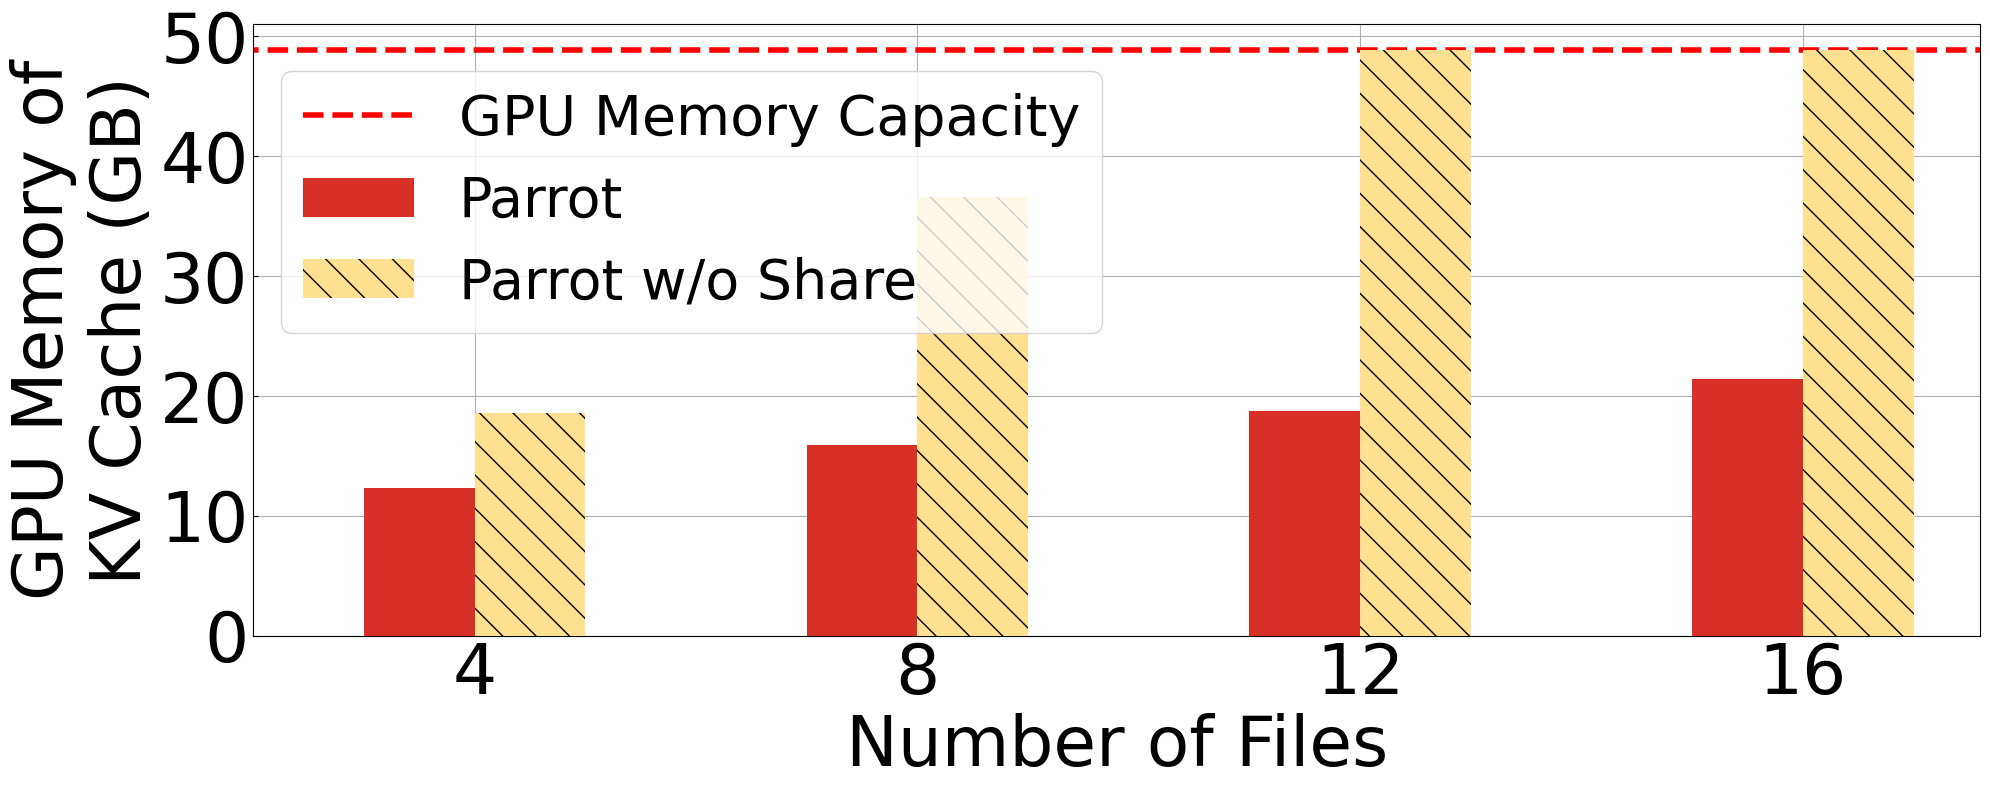

In [354]:

names = {
    'shared': 'Parrot',
    'w/o shared': 'Parrot w/o Share'
}
data = {
    'shared': shared,
    'w/o shared': no_shared
}
systems = ['shared', 'w/o shared']
# Generate the chart
x = np.arange(len(branch_nums))
width = 0.25

fig, ax = plt.subplots(1, 1, figsize=(20,8))

plt.grid(True)
rects = []
for i, system in enumerate(systems):
    
    rect = ax.bar(x - width/2 + i*width, [_*12.5/1024 for _ in data[system]], width,  hatch = hatches[i], color = colors[i], label=names[system],zorder=3) # hatches
    rects.append(rect)
plt.plot([-1,4],[4000*12.5/1024, 4000*12.5/1024], '--', color = 'r', label = 'GPU Memory Capacity', linewidth=4)
plt.xlim([-0.5,3.4])
# ax.text(2.05, 0.6, 'x', color='r', fontsize=30)
# ax.text(3.05, 0.6, 'x', color='r', fontsize=30)
# plt.legend(loc='upper left', prop = { "size": 18 },)
ax.tick_params(axis='y', labelsize=50, direction='in')
ax.tick_params(axis='x', labelsize=50, direction='in')
ax.set_xlabel('Number of Files', fontsize=50)
ax.set_ylabel('GPU Memory of\nKV Cache (GB)', fontsize=50)
ax.set_xticks([_ for _ in x])
ax.set_xticklabels(branch_nums)
plt.yticks([_ for _ in range(0,55,10)])
plt.ylim([0,51])
plt.legend(loc='upper left', prop = { "size": 40 }, bbox_to_anchor= (0., 0.97))

plt.tight_layout()
plt.savefig('multiagent_mem.pdf')